# MNIST Dataset

In [1]:
# import the dataset from sklearn
from sklearn.datasets import fetch_openml
import numpy as np

In [2]:
# fetch the MNIST dataset and store it 
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# load the data and the target
X, y = mnist['data'], mnist['target']

# take a look at the shape of the dataset
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

print(type(X))
print(type(y))
print(type(y[0]))

# convert str to int
y = y.astype(np.uint8)
print(type(y[0]))

X.shape:  (70000, 784)
y.shape:  (70000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'str'>
<class 'numpy.uint8'>


# Visualization
Thus we have 70000 samples, each of which has 784 features, which stands for the 28*28 pixels.
Our next step is to visualize an image to get a feel for the dataset.

In [4]:
# some imports for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
# reshape the image before plotting
first_digit = X[0]
print(type(first_digit))
print('raw shape', first_digit.shape)

first_digit = first_digit.reshape(28,28)
print('new shape', first_digit.shape)

<class 'numpy.ndarray'>
raw shape (784,)
new shape (28, 28)


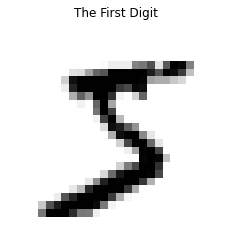

y label:  5


In [6]:
# plot the image
plt.imshow(first_digit, cmap='binary') # try without the cmap argument, plt.imshow(first_digit)
plt.axis('off')
plt.title('The First Digit')
plt.show()

# print the y label of this image
print('y label: ', y[0])

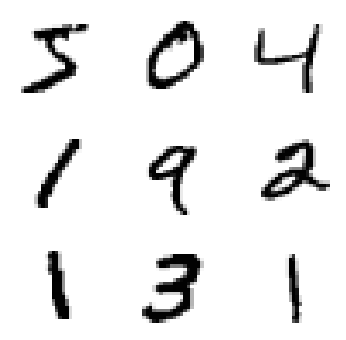

In [7]:
# We can define our own function of visualization, plot n square images.
def plot_some_images(image_set, n):
    plt.figure(figsize=(n*2,n*2))
    for i in range(n**2):
        digit = image_set[i].reshape(28,28)
        plt.subplot(n,n,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.imshow(digit, cmap = 'binary')

plot_some_images(X, 3)
plt.show()

# First Train
Now that we see what's going on in the dataset, we want to predict some numbers using a model. So we need to divde the dataset into a training set and a test set (we'll do validation set later).

In [8]:
# divide the dataset into a ratio of 6:1 for the training set and the test set repsectively. 
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

To start, we can train a binary classifier between one digit and all the rest instead of a multi-class classifier distingushing
all the numbers. We'll pick 0 in this case.

In [9]:
# label the data true if 0, else False
y_train_0 = (y_train == 0)
y_test_0 = (y_test == 0)

# to see what's ging on 
print(y_test_0[:10])

[False False False  True False False False False False False]


In [10]:
# Using Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier
# clf stands for classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_0) 

SGDClassifier(random_state=42)

In [11]:
print('train accuracy score', sgd_clf.score(X_train, y_train_0))
print('test accuracy score: ', sgd_clf.score(X_test, y_test_0))

from sklearn.metrics import confusion_matrix

y_pred = sgd_clf.predict(X_test)
print(confusion_matrix(y_test_0, y_pred))

train accuracy score 0.99155
test accuracy score:  0.9894
[[8953   67]
 [  39  941]]


# Cross Validation
Now we are down to do some cross validation. 

In [12]:
# implementing cross validation

from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.base import clone

# split the training data into 3 folds  
folds = SKF(n_splits=3)

# see what the split method does 
for train_index, test_index in folds.split(X_train, y_train_0):
    print(train_index, test_index)

[19845 19856 19857 ... 59997 59998 59999] [    0     1     2 ... 20019 20020 20021]
[    0     1     2 ... 59997 59998 59999] [19845 19856 19857 ... 40180 40188 40199]
[    0     1     2 ... 40180 40188 40199] [39974 39976 39977 ... 59997 59998 59999]


In [13]:
from sklearn.metrics import precision_score, recall_score

# perform cross_validation and output accuracy / precision / recall
def custom_cross_validation(n_folds, X_train, y_train, metric='accuracy'):
    
    # if metric not right, raise error
    if metric not in ['accuracy', 'precision', 'recall']: raise Exception('unknown metric')
    
    folds = SKF(n_splits = n_folds)
    
    score_lst = []
    for train_index, test_index in folds.split(X_train, y_train):
        clone_clf = clone(sgd_clf)
        # get the train folds
        X_train_folds = X_train[train_index]
        y_train_folds = y_train[train_index]
        # get the test folds
        X_test_fold = X_train[test_index]
        y_test_fold = y_train[test_index]
        
        # train the train folds and test against the test fold to get the score
        clone_clf.fit(X_train_folds, y_train_folds)
        
        # predict on the validation set 
        if metric == 'accuracy':
            score_lst.append(clone_clf.score(X_test_fold, y_test_fold))
        else:
            y_test_pred = clone_clf.predict(X_test_fold)
            if metric == 'precision':
                score_lst.append(precision_score(y_test_fold, y_test_pred))
            else:
                score_lst.append(recall_score(y_test_fold, y_test_pred))
    return score_lst
        
score_lst = custom_cross_validation(3, X_train, y_train_0, 'recall')
print('cross validation scores: ', score_lst)

cross validation scores:  [0.9620060790273556, 0.9660587639311043, 0.9316455696202531]


In [14]:
# Now let's move to the built-in cross validation method
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring='accuracy')

array([0.9854, 0.9847, 0.9865])

# Looks good?
The cross validation scores seems pretty good. But since only 10% of the data has 0 as its actual label, if we simply classify everything as non-zero, we would still get a score of around 90%. Thus accuracy might not be a good

In [15]:
from sklearn.base import BaseEstimator

class Never0Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros([len(X),1],dtype=bool)

dumb_clf = Never0Classifier()
cross_val_score(dumb_clf, X_train, y_train_0, cv=3, scoring='accuracy')

array([0.9003 , 0.9035 , 0.90005])

In [16]:
# However, we can use recall and precision to see their differences.
from sklearn.metrics import precision_score, recall_score

y_test_pred = sgd_clf.predict(X_test)
y_dumb_pred = dumb_clf.predict(X_test)

print('test set precision:', precision_score(y_test_0, y_test_pred))
print('test set recall: ', recall_score(y_test_0, y_test_pred))

print('dumb precision:', precision_score(y_test_0, y_dumb_pred))
print('dumb recall: ', recall_score(y_test_0, y_dumb_pred))

test set precision: 0.933531746031746
test set recall:  0.960204081632653
dumb precision: 0.0
dumb recall:  0.0


C:\Users\mil_kry\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Precision-Recall-Trade-Off

There is a trade off between precision and recall. At default, score threshold is 0 and a sample gets classified as positive if and only if the score is greater than 0. The higher the score threshold is, the higher the precision and the lower the recall, since it gets harder and harder for negative samples to reach such a demanding score while positive samples get filtered more frequently. On the other hand, the lower the threshold, the higher the Recall and the lower the Precision.  

Also, we are going to try different ways to measure the performance of our model.

In [17]:
from sklearn.model_selection import cross_val_predict

# specify method to return scores instead of labels
y_scores = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3, method='decision_function')

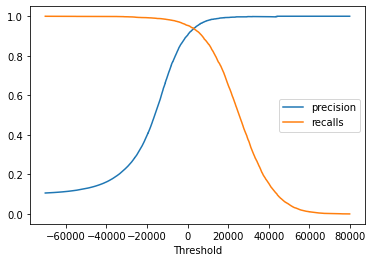

In [18]:
# plot the precision-recall-threshold curve

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)
                                                         
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], label = 'precision')
    plt.plot(thresholds, recalls[:-1], label = 'recalls')
    plt.xlabel('Threshold')
    plt.legend()

plot_precision_recall_threshold(precisions, recalls, thresholds)


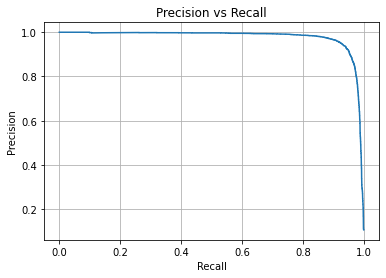

In [19]:
# We can also plot precision against recall
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall')
    plt.grid()
    
plot_precision_recall(precisions, recalls)

In [20]:
# Let's say we want a model with exactly 95% precision

# find the first index where precisions>=0.95 evaluates to True
threshold_95p = thresholds[np.argmax(precisions >= 0.95)]

y_train_95p_pred = (y_scores >= threshold_95p)

# print out the respective precision and recall
print('precision score: ', precision_score(y_train_0, y_train_95p_pred))
print('recall score: ', recall_score(y_train_0, y_train_95p_pred))

precision score:  0.9501039501039501
recall score:  0.9258821543136924


In [21]:
# The ROC Curve plot the True positive rate against the False positive rate. 
# ROC AUC provides the area under the curve for ROC.

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

print('ROC AUC score:', roc_auc_score(y_train_0, y_scores))

ROC AUC score: 0.9951089652363219


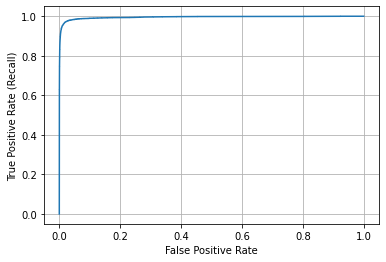

In [22]:
# plot the roc curve 
plt.plot(fpr, tpr, label='SGD')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.show()

# Compare with Random Forest 

In [23]:
from sklearn.ensemble import RandomForestClassifier as RF 

forest_clf = RF()

# predict_proba provides probability for both classes 
y_RF = cross_val_predict(forest_clf, X_train, y_train_0, cv=3, method='predict_proba')

# we only need the positive class
y_score_RF = y_RF[:,1]

# get the fpr, tpr
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_train_0, y_score_RF)

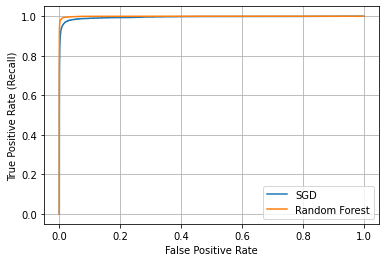

In [24]:
# compare the roc curves
plt.plot(fpr, tpr, label='SGD')
plt.plot(fpr_RF, tpr_RF, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.legend()
plt.show()

# Training Set Expansion
We can shift an image a little bit to get a new image with very different pixel positions. We can shift left, right, up, and down to get 4 more copies of an original image. Put them together and we can have 300,000 images.  

In [27]:
from scipy.ndimage.interpolation import shift
# training set augmentation 
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    # use the scipy shift smethod
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [31]:
# train a model using KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# we can do a grid search, but it takes hours. 
knn = KNeighborsClassifier()
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors':  [4, 5]}]
grid_search = GridSearchCV(knn, param_grid, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
# the best parameters are given by 
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn.fit(X_train_augmented, y_train_augmented)
knn.score(X_test, y_test)